# SSVQE Excited-State Simulation of H₃⁺

This notebook computes the **ground** and **first excited state** of H₃⁺
using the **Subspace-Search VQE (SSVQE)** algorithm.

- Ansatz: UCC-style singles + doubles
- Optimizer: Adam
- Device: default.qubit (noiseless)
- Output: Convergence of E₀ and E₁, excitation energy ΔE

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

import sys, os, json
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.vqe_utils import (
    IMG_DIR,
    excitation_ansatz,
    get_optimizer,
    set_seed,
    ensure_dirs,
    make_run_config_dict,
    run_signature,
    find_existing_run,
    save_run_record,
    build_run_filename,
)

ensure_dirs()

In [2]:
# Molecule setup
seed = 0
set_seed(seed)

symbols = ["H", "H", "H"]
coordinates = np.array([
    [0.000000,  1.000000,  0.000000],
    [-0.866025, -0.500000, 0.000000],
    [ 0.866025, -0.500000, 0.000000],
])
basis = "STO-3G"
electrons = 2

hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=+1, basis=basis
)
hf = qchem.hf_state(electrons, qubits)

singles, doubles = qchem.excitations(electrons, qubits)
singles = [tuple(x) for x in singles]
doubles = [tuple(x) for x in doubles]

n_params = len(singles) + len(doubles)
num_wires = qubits

In [3]:
# SSVQE QNodes

dev = qml.device("default.qubit", wires=num_wires)

def state_circuit(params):
    excitation_ansatz(
        params,
        wires=range(num_wires),
        hf_state=hf,
        excitations=(singles, doubles),
    )

@qml.qnode(dev)
def energy_expectation(params):
    state_circuit(params)
    return qml.expval(hamiltonian)

@qml.qnode(dev)
def overlap(params1, params2):
    excitation_ansatz(params1, wires=range(num_wires), hf_state=hf, excitations=(singles, doubles))
    qml.adjoint(state_circuit)(params2)
    return qml.probs(wires=range(num_wires))

def overlap00(p0, p1):
    return overlap(p0, p1)[0]

In [4]:
# SSVQE driver (cache-aware)

def run_ssvqe_with_cache(stepsize=0.4, max_iter=75, penalty_weight=10.0):
    ansatz_desc = "SSVQE UCC singles+doubles"
    optimizer_name = "Adam"

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iter,
        seed=seed,
    )
    cfg["penalty_weight"] = float(penalty_weight)

    sig = run_signature(cfg)
    fname = build_run_filename("H3plus_SSVQE", optimizer_name, seed, sig)
    existing = find_existing_run(sig)

    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] loaded {existing}")
        return {
            "E0_list": rec["E0_list"],
            "E1_list": rec["E1_list"],
            "final_params": np.array(rec["final_params"]),
        }

    # Cost function
    def ssvqe_cost(params):
        p0 = params[:n_params]
        p1 = params[n_params:]
        E0 = energy_expectation(p0)
        E1 = energy_expectation(p1)
        penalty = penalty_weight * overlap00(p0, p1)
        return E0 + E1 + penalty

    params = np.zeros(2 * n_params, requires_grad=True)
    opt = get_optimizer(optimizer_name, stepsize=stepsize)

    E0_list, E1_list = [], []
    for _ in range(max_iter):
        params, _ = opt.step_and_cost(ssvqe_cost, params)
        p0 = params[:n_params]
        p1 = params[n_params:]
        E0_list.append(float(energy_expectation(p0)))
        E1_list.append(float(energy_expectation(p1)))

    run_record = {
        "timestamp": __import__("time").strftime("%Y-%m-%d %H:%M:%S"),
        "molecule": "H3plus",
        "symbols": symbols,
        "geometry": coordinates.tolist(),
        "basis": basis,
        "electrons": electrons,
        "num_wires": num_wires,
        "algorithm": "SSVQE",
        "ansatz": ansatz_desc,
        "optimizer": {
            "name": optimizer_name,
            "stepsize": stepsize,
            "iterations_planned": max_iter,
            "iterations_ran": len(E0_list),
        },
        "seed": seed,
        "penalty_weight": penalty_weight,
        "E0_list": E0_list,
        "E1_list": E1_list,
        "final_params": [float(x) for x in params],
        "config_hash": sig,
    }

    save_run_record(fname, run_record)
    print(f"[saved] {fname}")
    return {"E0_list": E0_list, "E1_list": E1_list, "final_params": params}

In [5]:
# Run SSVQE

res = run_ssvqe_with_cache(
    stepsize=0.4,
    max_iter=100,
    penalty_weight=10.0,
)

E0_list = res["E0_list"]
E1_list = res["E1_list"]
params = res["final_params"]

[saved] H3plus_SSVQE_Adam_s0__ee06aabee587


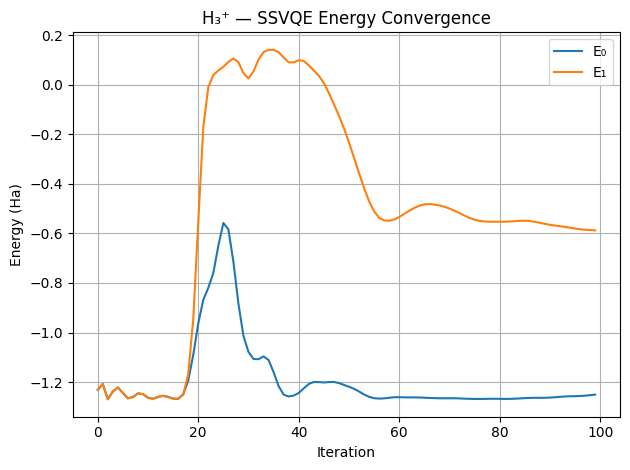

In [6]:
# Convergence plot

plt.plot(E0_list, label="E₀")
plt.plot(E1_list, label="E₁")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₃⁺ — SSVQE Energy Convergence")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f"{IMG_DIR}/H3plus_SSVQE_Adam.png", dpi=300)
plt.show()

In [7]:
# Final energies

final_E0 = E0_list[-1]
final_E1 = E1_list[-1]
delta_E = final_E1 - final_E0

print(f"E₀ = {final_E0:.8f} Ha")
print(f"E₁ = {final_E1:.8f} Ha")
print(f"ΔE = {delta_E:.8f} Ha")

E₀ = -1.25054229 Ha
E₁ = -0.58759689 Ha
ΔE = 0.66294540 Ha


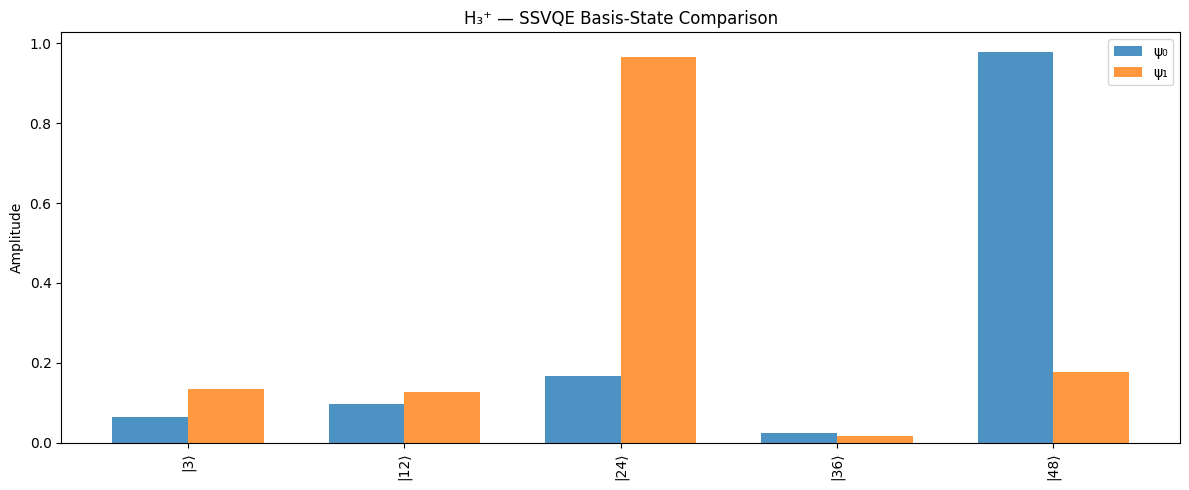

In [8]:
# Statevector comparison

@qml.qnode(dev)
def get_state(params):
    excitation_ansatz(params, wires=range(num_wires), hf_state=hf, excitations=(singles, doubles))
    return qml.state()

psi_0 = get_state(params[:n_params])
psi_1 = get_state(params[n_params:])

threshold = 1e-2
indices = np.unique(np.where((np.abs(psi_0) > threshold) | (np.abs(psi_1) > threshold))[0])

labels = [f"|{i}⟩" for i in indices]
amp0 = [np.abs(psi_0[i]) for i in indices]
amp1 = [np.abs(psi_1[i]) for i in indices]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, amp0, width, alpha=0.8, label="ψ₀")
plt.bar(x + width/2, amp1, width, alpha=0.8, label="ψ₁")
plt.xticks(x, labels, rotation=90)
plt.ylabel("Amplitude")
plt.title("H₃⁺ — SSVQE Basis-State Comparison")
plt.legend()
plt.tight_layout()

plt.savefig(f"{IMG_DIR}/H3plus_SSVQE_State_Comparison.png", dpi=300)
plt.show()